# Inititalize

In [1]:
cd /workspace

/workspace


/home/user/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [14]:
!sudo chmod -R 777 /workspace/

In [15]:
!git clone https://github.com/Vadim200116/gsplat.git

Cloning into 'gsplat'...
remote: Enumerating objects: 4635, done.
remote: Counting objects: 100% (1491/1491), done.
remote: Compressing objects: 100% (461/461), done.
remote: Total 4635 (delta 1176), reused 1138 (delta 1027), pack-reused 3144 (from 1)
Receiving objects: 100% (4635/4635), 207.88 MiB | 5.27 MiB/s, done.
Resolving deltas: 100% (3013/3013), done.


In [2]:
cd gsplat/

/workspace/gsplat


In [31]:
!pip3 install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///workspace/gsplat
  Preparing metadata (setup.py) ... done
  Attempting uninstall: gsplat
    Found existing installation: gsplat 1.0.0
    Uninstalling gsplat-1.0.0:
      Successfully uninstalled gsplat-1.0.0
  Running setup.py develop for gsplat
    error: subprocess-exited-with-error
    
    × python setup.py develop did not run successfully.
    │ exit code: 1
    ╰─> [134 lines of output]
        Setting MAX_JOBS to 10
        running develop
        /home/user/.local/lib/python3.10/site-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
        !!
        
                ********************************************************************************
                Please avoid running ``setup.py`` and ``easy_install``.
                Instead, use pypa/build, pypa/installer or other
                standards-based tools.
  

In [17]:
!git checkout spot_splats

Branch 'spot_splats' set up to track remote branch 'spot_splats' from 'origin'.
Switched to a new branch 'spot_splats'


In [3]:
cd examples/

/workspace/gsplat/examples


In [19]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/rmbrualla/pycolmap (to revision cc7ea4b7301720ac29287dbe450952511b32125e) to /tmp/pip-req-build-sxdlc7iz
  Running command git clone --filter=blob:none --quiet https://github.com/rmbrualla/pycolmap /tmp/pip-req-build-sxdlc7iz
  Running command git rev-parse -q --verify 'sha^cc7ea4b7301720ac29287dbe450952511b32125e'
  Running command git fetch -q https://github.com/rmbrualla/pycolmap cc7ea4b7301720ac29287dbe450952511b32125e
  Resolved https://github.com/rmbrualla/pycolmap to commit cc7ea4b7301720ac29287dbe450952511b32125e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB

In [4]:
import torch
import numpy as np
from torch import nn
import os
import matplotlib.pyplot as plt
from utils import get_positional_encodings
try:
    from custom_trainer import Runner, Config
    from utils import TransientModule
    model_name = "gsplat"
except:
    from spotless_trainer import Runner, Config
    from utils import SpotLessModule
    model_name = "spotless-splats"


In [5]:
import json
model_dir = f"/data/output/{model_name}/onthego/corner"
cfg = Config()
json_cfg = json.load(open(model_dir + "/cfg.json"))

for k, v in json_cfg.items():
    setattr(cfg, k, v)
cfg.disable_viewer = True

In [6]:
runner = Runner(cfg)

[Parser] 122 images, taken by 1 cameras.
Scene scale: 2.0229848187962696
Model initialized. Number of GS: 40382


In [7]:
ckpt = torch.load(os.path.join(model_dir, "ckpts/ckpt_29999.pt"), map_location=runner.device)
for k in runner.splats.keys():
    runner.splats[k].data = ckpt["splats"][k]

In [8]:
runner.spotless_module = SpotLessModule(num_classes=1, num_features=runner.trainset[0]["semantics"].shape[0] + 80).cuda()
runner.spotless_module.load_state_dict(torch.load(os.path.join(model_dir, "ckpts/spotless_module_29999.pt")))

<All keys matched successfully>

In [67]:
def pred_mask(runner, idx):
    device = runner.device
    data = runner.trainset[idx]
    pixels = (data["image"].to(device) / 255.0).unsqueeze(0)
    if runner.cfg.semantics:
        sf = data["semantics"].to(device).unsqueeze(0)
        sf = nn.Upsample(
            size=(pixels.shape[1], pixels.shape[2]),
            mode="bilinear",
        )(sf).squeeze(0)
        pos_enc = get_positional_encodings(
            pixels.shape[1], pixels.shape[2], 20
        ).permute((2, 0, 1))
        sf = torch.cat([sf, pos_enc], dim=0)
        sf_flat = sf.reshape(sf.shape[0], -1).permute((1, 0))
        runner.spotless_module.eval()
        pred_mask_up = runner.spotless_module(sf_flat)
        mask = pred_mask_up.reshape(pixels.shape[1], pixels.shape[2])
    return mask

def mask_frame(frame, mask):
    mask_ = np.expand_dims(np.array(mask.detach().cpu().numpy()), 2).repeat(3, axis=2)
    h,w = frame.shape[:2]
    green = np.zeros([h, w, 3]) 
    green[:,:,1] = 255
    alpha = 0.6
    fuse_img = (1-alpha) * frame + alpha * green
    fuse_img = (1-mask_) * fuse_img + mask_ * frame

    return fuse_img.astype(np.uint8)

def plot_images_titles(images, titles=None, nrows=1, ncols=2):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
    fig.subplots_adjust(hspace=0, wspace=0)

    if not titles:
        titles = [str(i) for i in range(len(images))]
    for ax, img, title in zip(axs.ravel(), images[:nrows*ncols], titles[:nrows*ncols]):
        ax.imshow(np.array(img), cmap="gray")
        ax.set_title(title)
        ax.axis('off')

def render_img(runner, idx):
    device = runner.device
    data = runner.trainset[idx]

    pixels = data["image"].unsqueeze(0).to(device)
    camtoworlds = data["camtoworld"].to(device).unsqueeze(0)
    Ks = data["K"].to(device).unsqueeze(0)
    height, width = pixels.shape[1:3]
    colors, _, _ = runner.rasterize_splats(
        camtoworlds=camtoworlds,
        Ks=Ks,
        width=width,
        height=height,
        sh_degree=cfg.sh_degree,
        near_plane=cfg.near_plane,
        far_plane=cfg.far_plane,
    )  # [1, H, W, 3]
    colors = torch.clamp(colors, 0.0, 1.0)
              
    error_per_pixel = torch.abs(colors-pixels/255)
    return colors, error_per_pixel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..9.105915].


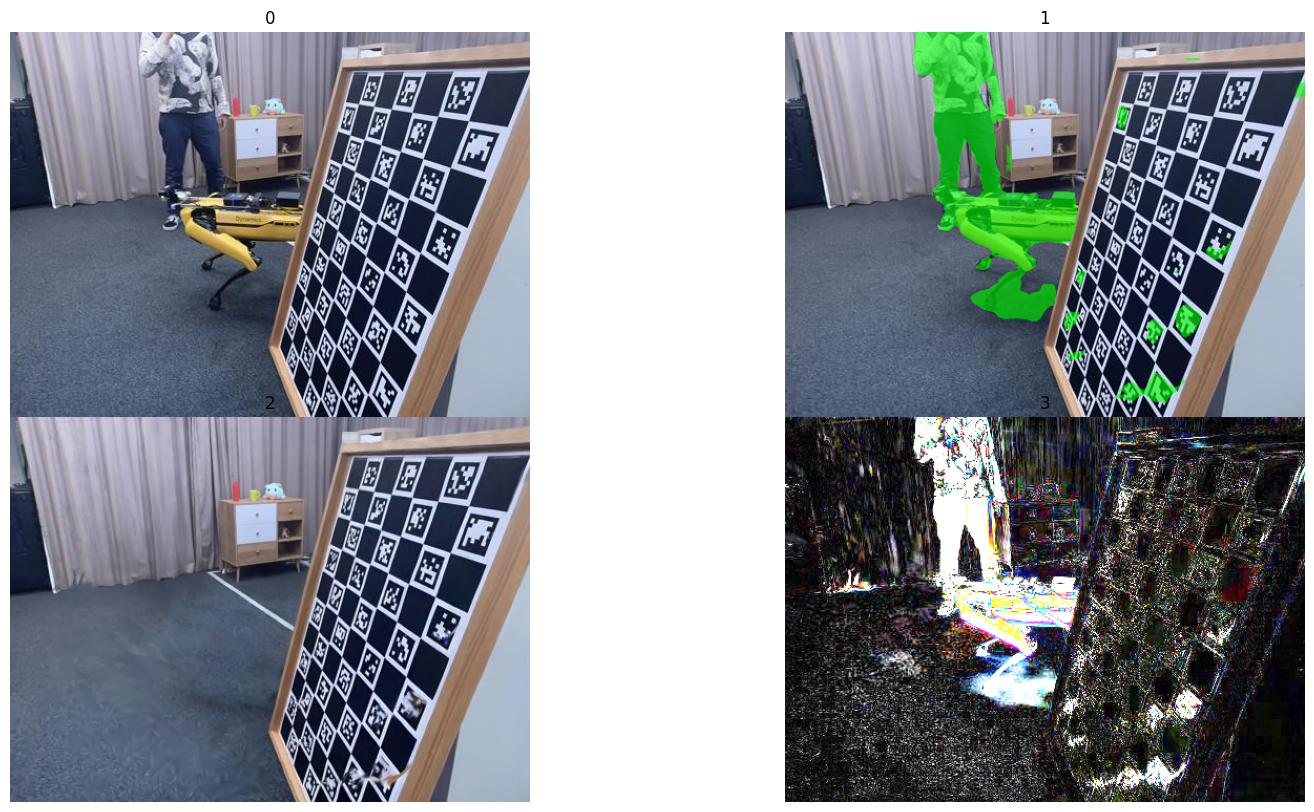

In [75]:
idx = 60
mask = pred_mask(runner, idx)
img = runner.trainset[idx]["image"]
img_prep = img.cpu().numpy() / 255

rend_img, diff = render_img(runner, idx)

diff_prep =  diff.squeeze().detach().cpu().numpy()
rend_img_prep = rend_img.squeeze(0).detach().cpu().numpy()

plot_images_titles((img_prep, mask_frame(img.cpu().numpy(), mask), rend_img_prep, diff_prep*10), nrows=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..9.105915].


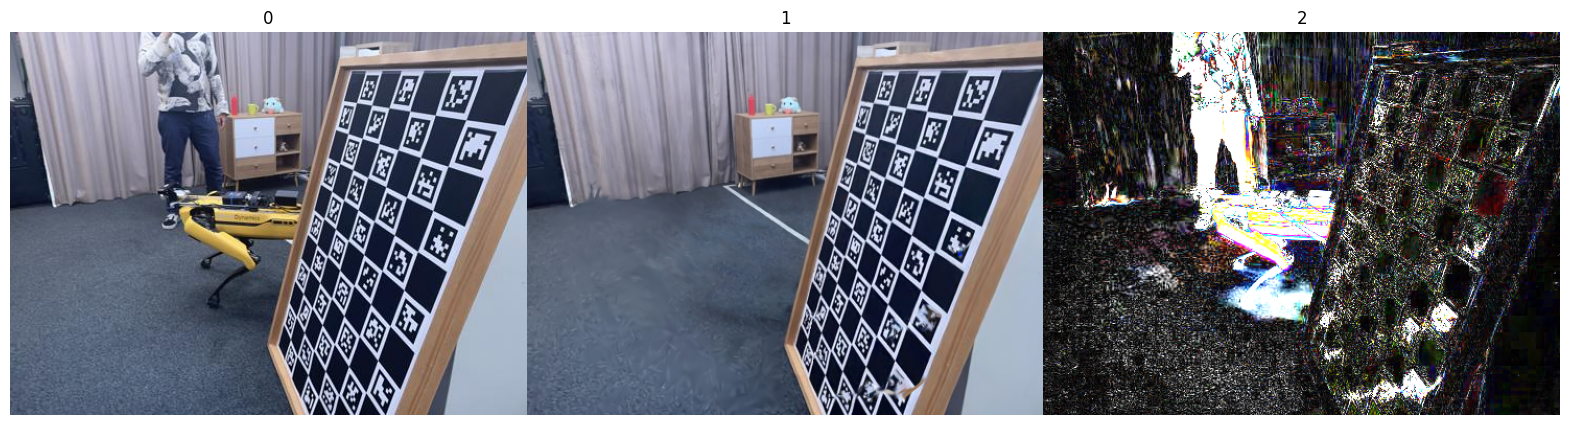

In [82]:
plot_images_titles((img_prep, rend_img_prep, (diff_prep)*10), ncols=3)

# resize images

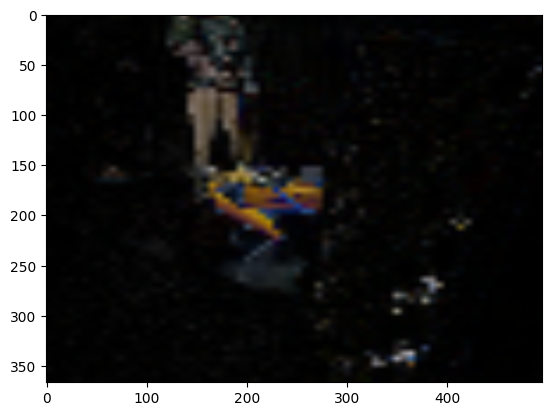

In [138]:
import cv2

size  = (70, 70)
img_r = cv2.resize(img_prep, size)
rend_img_r = cv2.resize(rend_img_prep, size)
diff_r = np.abs(img_r - rend_img_r)
diff_new = cv2.resize(diff_r, (img_prep.shape[1],img_prep.shape[0]))
plt.imshow(diff_new)

# blur images

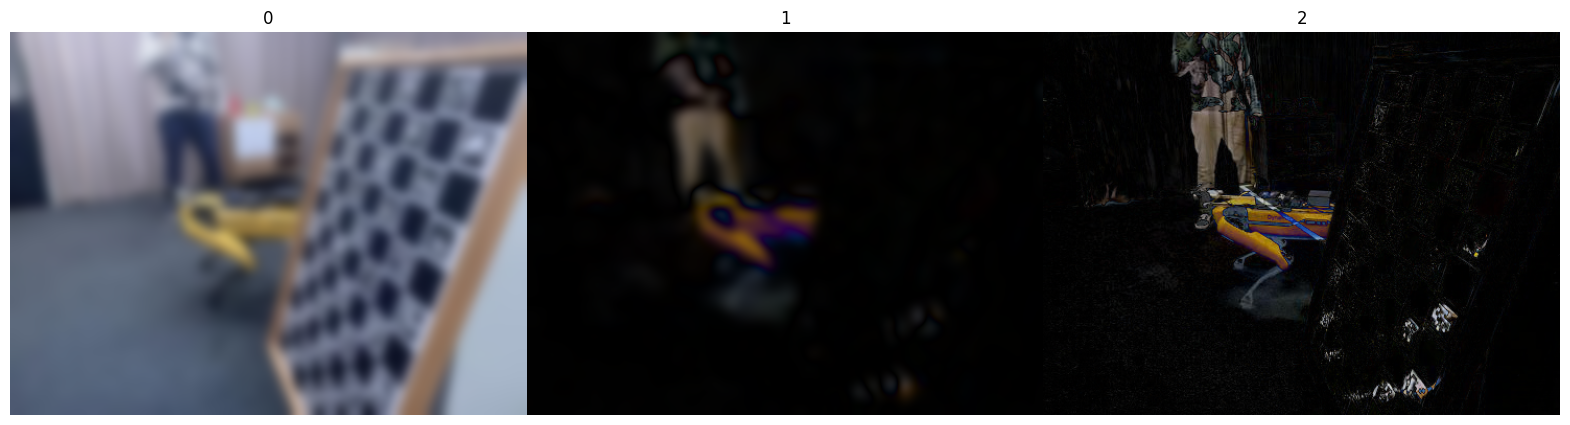

In [127]:
import cv2
kernel = (35, 35)
img_r = cv2.GaussianBlur(img_prep, kernel, 0)
rend_img_r = cv2.GaussianBlur(rend_img_prep, kernel, 0)

diff_new = np.abs(img_r - rend_img_r)
plot_images_titles((img_r, diff_new, diff_prep), ncols=3)

In [134]:
import cv2
kernel = 7
img_r = cv2.bilateralFilter(img_prep, kernel)
rend_img_r = cv2.bilateralFilter(rend_img_prep, kernel)

diff_new = np.abs(img_r - rend_img_r)
plot_images_titles((img_r, diff_new, diff_prep), ncols=3)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/median_blur.simd.hpp:880: error: (-215:Assertion failed) src.depth() == CV_8U && (cn == 1 || cn == 3 || cn == 4) in function 'medianBlur'
